Limits Generator

In [2]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits
from utilities_widgets import position_chart, widget_selector, widget_int_entry
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
means_calculation = widget_selector(options=['Global means', 'Per position means'], description='Means algorithm', tooltips=['Calculate global means for each limit', 'Calculate means for each position'])
auto_position = widgets.Checkbox(value=False, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

In [3]:
##Database access
table_list = consult_database("input.db", verbose=False)
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter="_FixtureData_")[-1]
    file = '_'.join(fixture_data.split("_")[:-7])
except: #Resorts to using globals values
    file = re.sub(r'\W', '_', glob.tooling)
try: #Tries to search for the last tables related to the fixture data
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[-1]
except Exception as e:
    raise Exception("Missing the required tables. Ensure you have the required tables.")
try: #Tries to find a table for the fixture data to compose
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'})

In [4]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "FixtureData" in string), None), index_col="index")
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('INAMARSA_Fixtu…

Table *INAMARSA_Measurements_2024y_03m_21d_11h_48m_04s* retrieved succesfully.
Table *INAMARSA_Limits_2024y_03m_21d_11h_48m_04s* retrieved succesfully.
Table *INAMARSA_FixtureData_2024y_05m_07d_13h_36m_25s* retrieved succesfully.


In [5]:
##Mean dataframe creation
display(means_calculation)
if means_calculation.value == 'Global means':
    means_df = mean_calculator(MEAS) #Global means version
elif means_calculation.value == 'Per position means':
    means_df = mean_calculator(MEAS, glob.lenses_per_nest) #Per position means version
means_df_format = rename_index(means_df)
means_df_format

ToggleButtons(description='Means algorithm', options=('Global means', 'Per position means'), tooltips=('Calcul…

,mean
Guia_Luz_Blanco_FB1_X,0.330608
Guia_Luz_Blanco_FB1_Y,0.355542
Guia_Luz_Blanco_FB2_X,0.330608
Guia_Luz_Blanco_FB2_Y,0.355542
Guia_Luz_Blanco_FB3_X,0.330608
Guia_Luz_Blanco_FB3_Y,0.355542
Guia_Luz_Blanco_FB4_X,0.330608
Guia_Luz_Blanco_FB4_Y,0.355542
Guia_Luz_Blanco_FB5_X,0.330608
Guia_Luz_Blanco_FB5_Y,0.355542


In [6]:
##Rearanged limits dataframe calculation
new_limits = limits_generator(means_df)
limits_format = rename_index(new_limits)
print("Adjusted limits")
limits_format

Adjusted limits


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.318108,0.343108
Guia_Luz_Blanco_FB1_Y,0.339042,0.372042
Guia_Luz_Blanco_FB2_X,0.318108,0.343108
Guia_Luz_Blanco_FB2_Y,0.339042,0.372042
Guia_Luz_Blanco_FB3_X,0.318108,0.343108
Guia_Luz_Blanco_FB3_Y,0.339042,0.372042
Guia_Luz_Blanco_FB4_X,0.318108,0.343108
Guia_Luz_Blanco_FB4_Y,0.339042,0.372042
Guia_Luz_Blanco_FB5_X,0.318108,0.343108
Guia_Luz_Blanco_FB5_Y,0.339042,0.372042


In [7]:
##Data review
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
output = pd.concat([MEAS_format, limits_format], axis=1) #Concatenates the measures and limits
output

,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 18,test: 19,test: 20,test: 21,test: 22,test: 23,test: 24,test: 25,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.3258,0.3259,0.3258,0.3257,0.3257,0.3258,0.3257,0.3257,0.3259,0.3258,...,0.3257,0.3257,0.3259,0.3259,0.3259,0.3257,0.3259,0.3259,0.318108,0.343108
Guia_Luz_Blanco_FB1_Y,0.3531,0.3532,0.3531,0.3530,0.3530,0.3531,0.3530,0.3530,0.3532,0.3531,...,0.3530,0.3530,0.3532,0.3532,0.3531,0.3531,0.3531,0.3532,0.339042,0.372042
Guia_Luz_Blanco_FB2_X,0.3323,0.3323,0.3322,0.3324,0.3323,0.3323,0.3322,0.3322,0.3322,0.3322,...,0.3323,0.3323,0.3324,0.3324,0.3325,0.3322,0.3323,0.3324,0.318108,0.343108
Guia_Luz_Blanco_FB2_Y,0.3580,0.3580,0.3579,0.3580,0.3579,0.3580,0.3579,0.3579,0.3579,0.3579,...,0.3580,0.3579,0.3580,0.3581,0.3581,0.3580,0.3580,0.3581,0.339042,0.372042
Guia_Luz_Blanco_FB3_X,0.3256,0.3256,0.3253,0.3254,0.3253,0.3254,0.3253,0.3253,0.3255,0.3254,...,0.3251,0.3252,0.3251,0.3252,0.3251,0.3253,0.3252,0.3252,0.318108,0.343108
Guia_Luz_Blanco_FB3_Y,0.3568,0.3568,0.3566,0.3566,0.3566,0.3566,0.3566,0.3566,0.3567,0.3566,...,0.3565,0.3565,0.3564,0.3565,0.3565,0.3566,0.3566,0.3566,0.339042,0.372042
Guia_Luz_Blanco_FB4_X,0.3278,0.3276,0.3275,0.3275,0.3277,0.3278,0.3278,0.3278,0.3278,0.3276,...,0.3277,0.3277,0.3278,0.3278,0.3275,0.3276,0.3276,0.3275,0.318108,0.343108
Guia_Luz_Blanco_FB4_Y,0.3479,0.3478,0.3476,0.3477,0.3478,0.3479,0.3479,0.3479,0.3479,0.3478,...,0.3478,0.3479,0.3479,0.3479,0.3478,0.3478,0.3478,0.3478,0.339042,0.372042
Guia_Luz_Blanco_FB5_X,0.3302,0.3302,0.3302,0.3303,0.3301,0.3301,0.3301,0.3302,0.3302,0.3302,...,0.3296,0.3302,0.3302,0.3302,0.3302,0.3302,0.3303,0.3303,0.318108,0.343108
Guia_Luz_Blanco_FB5_Y,0.3546,0.3546,0.3546,0.3547,0.3546,0.3546,0.3546,0.3546,0.3546,0.3546,...,0.3541,0.3547,0.3546,0.3547,0.3547,0.3546,0.3547,0.3547,0.339042,0.372042


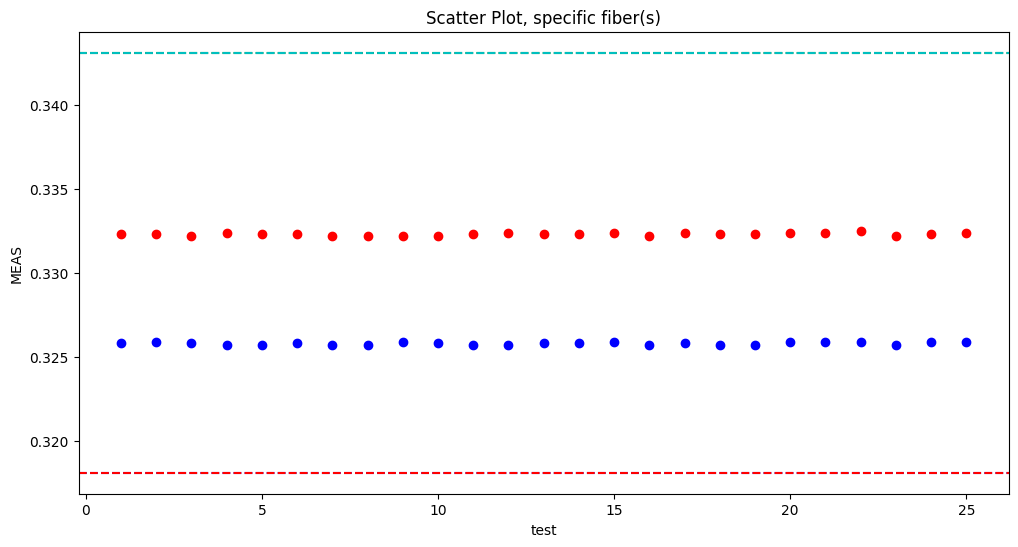

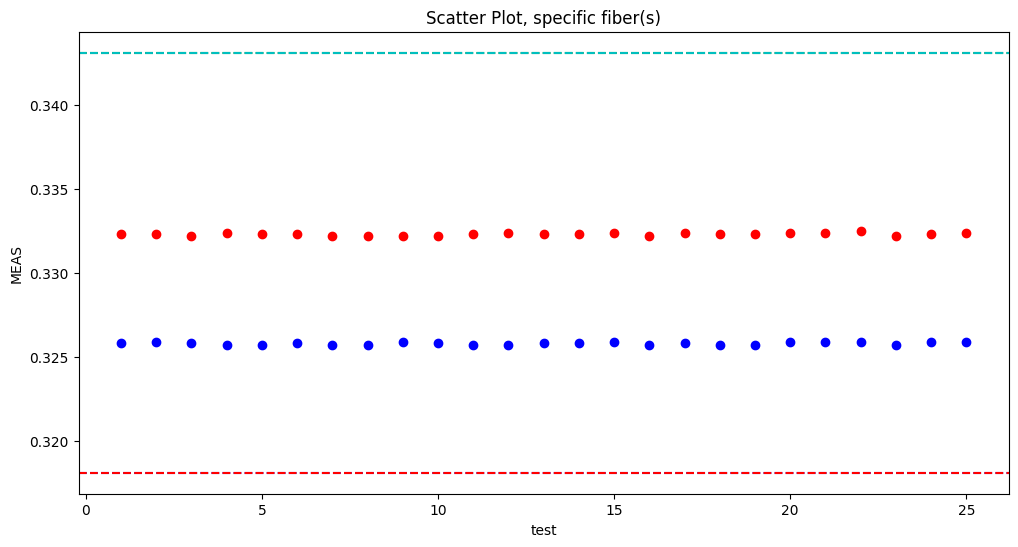

In [9]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([auto_position, mean_slider, range_slider]))
plot_scatter(MEAS, title='Scatter Plot, specific fiber(s)', xlabel='test', ylabel='MEAS', limits=new_limits, filter=[1, 3], yrange=yrange)

In [10]:
##Data export and limit file generation
name = glob.tooling + "_" + get_date() + ".xlsx"
confirmation = input("Do you want to export the data to a new Target.xlsx file and generate a new limits ini file? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output"), name)
    output.to_excel(output_filepath, index=True, header=True)
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    ini_generator(new_limits, glob.lenses_per_nest, glob.nests_number)
    print(f'Data exported inside: {output_filepath}')
    print(f'Limits generated at: {os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

[LIMITS_GENERIC]
Guia_Luz_Blanco_FB1_X_MAX = 0.3403
Guia_Luz_Blanco_FB1_X_MIN = 0.3153
Guia_Luz_Blanco_FB1_Y_MAX = 0.3664
Guia_Luz_Blanco_FB1_Y_MIN = 0.3334
Guia_Luz_Blanco_FB2_X_MAX = 0.3403
...
Data exported inside: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output\VA-007_2024y-01m-10d_8h-12m-45s.xlsx
Limits generated at: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output


In [ ]:
##Update of the database
name = re.sub(r'\W', '_', glob.tooling + "_" + get_date()) + "_limits&corrected"
confirmation = input("Do you want to export the new limits to your database (y/n): ").strip().lower()
if confirmation == 'y':
    prepare_database("input.db", new_limits, name) #Store a df for the limits inside the database of the project
    limits_file = rename_limits_table("output.db", name)
    print("Limit files renamed for clarity.")
    consult_database("input.db", verbose=True)
else:
    print("Operation canceled.")

Operation canceled.
